In [1]:
import numpy as np
import kf_book.book_plots as book_plots
from kf_book.book_plots import figsize, set_figsize
import matplotlib.pyplot as plt

In [2]:
belief = np.array([1/10]*10)
print(belief)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [3]:
A = [0] * 10
A[0] = 1
A[1] = 1
A[-2] = 1
hallway = np.array(A)
print(hallway)

[1 1 0 0 0 0 0 0 1 0]


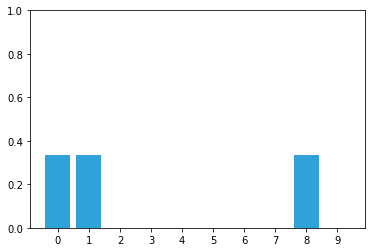

In [4]:
belief = hallway/3
book_plots.bar_plot(belief)

In [5]:
def update_belief(hall, belief, z, corrct_scale):
    for i, val in enumerate(hall):
        if val == z:
            belief[i] *= corrct_scale

[0.3 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.1]


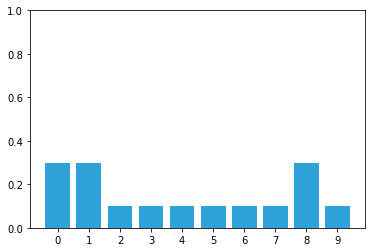

In [6]:
belief = np.array([0.1] * 10)
reading = 1
update_belief(hallway, belief, reading, corrct_scale=3.0)
print(belief)
book_plots.bar_plot(belief)

[0.1875 0.1875 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.1875 0.0625]


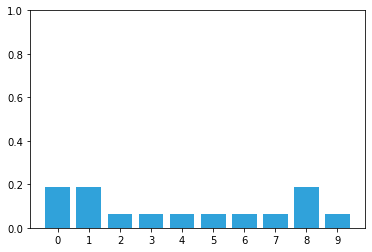

In [7]:
belief = belief/sum(belief)
book_plots.bar_plot(belief)
print(belief)

$$\Large
posterior = \frac{likelihood\times prior}{normalization}
$$

In [9]:
def scaled_update(hall, belief, z, z_prob):
    scale = z_prob * (1. - z_prob)
    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    likelihood *= belief
    return likelihood/sum(likelihood)

 <font size="6"> Likelihood is not probability distribution, because sum of the likelihood is not equal 1
</font>

In [11]:
from filterpy.discrete_bayes import normalize

In [47]:
def lh_hallway(hall, z, z_prob):
    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8
    likelihood = np.ones(len(hall))
    likelihood[hall == z] *= scale
    return likelihood

In [16]:
def update(likelihood, belief):
    return normalize(likelihood*belief)

In [17]:
belief = np.array([0.1] * 10)
likelihood = lh_hallway(hallway, z = 1, z_prob=0.75)
update(likelihood, belief)

array([0.1875, 0.1875, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.1875, 0.0625])

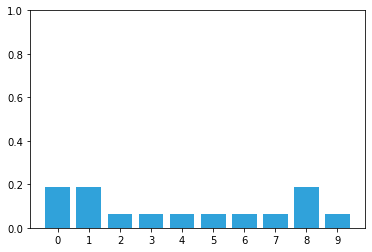

In [18]:
book_plots.bar_plot(update(likelihood, belief))

## Assume our movement sensor is pefect

In [21]:
def perfect_predict(belief, move):
    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = belief[(i-move)%n]
    return result

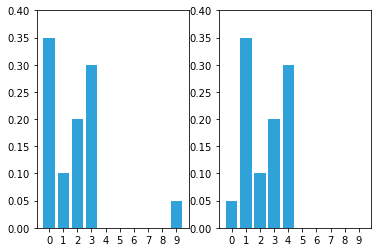

In [22]:
belief = np.array([0.35, 0.1, 0.2, 0.3, 0, 0, 0, 0, 0, 0.05])
plt.subplot(121)
book_plots.bar_plot(belief, ylim=(0, 0.4))
belief = perfect_predict(belief, 1)d
plt.subplot(122)
book_plots.bar_plot(belief, ylim=(0, 0.4))

In [23]:
from ipywidgets import interact, IntSlider

In [27]:
belief = np.array([0.35, 0.1, 0.2, 0.3, 0, 0, 0, 0, 0, 0.05])
perfect_beliefs = []
for _ in range(20):
    belief = perfect_predict(belief, 1)
    perfect_beliefs.append(belief)

def simulate(time_step):
    book_plots.bar_plot(perfect_beliefs[time_step], ylim = [0, 0.4])
    
interact(simulate, time_step = IntSlider(value=0, max=len(perfect_beliefs)-1))

interactive(children=(IntSlider(value=0, description='time_step', max=19), Output()), _dom_classes=('widget-in…

<function __main__.simulate(time_step)>

# Terminology

System: we are trying to model or filter


state: current configuration or value


evolution: one cycle of prediction and updating with a mesruement


## Assume our movement sensor is imperfect

In [28]:
def predict_move(belief, move, p_under, p_correct, p_over):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] = belief[(i-move)%n] * p_correct + belief[(i-move-1)%n] * p_over + belief[(i-move + 1)%n] * p_under
    return prior

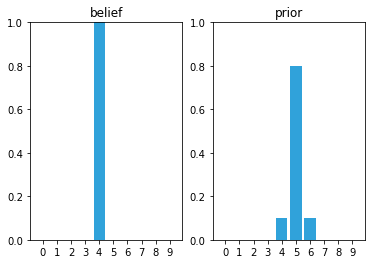

In [29]:
belief = [0] * 10
belief[4] = 1
belief = np.array(belief)
prior = predict_move(belief, 1, 0.1, 0.8, 0.1)
book_plots.plot_belief_vs_prior(belief, prior)

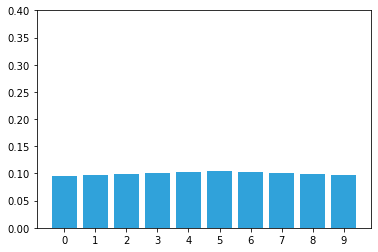

In [30]:
for i in range(100):
    prior = predict_move(prior, 1, 0.1, 0.8, 0.1)
book_plots.bar_plot(prior, ylim = (0., 0.4))

In [33]:
belief = [0] * 10
belief[0] = 1.
belief = np.array(belief)
predict_beliefs = []
for i in range(100):
    belief = predict_move(belief, 1, 0.1, 0.8, 0.1)
    predict_beliefs.append(belief)

def show_prior(step):
    book_plots.bar_plot(predict_beliefs[step])
    plt.title("step {}".format(step))
    
interact(show_prior, step = IntSlider(value=1, max=len(predict_beliefs)-1))

interactive(children=(IntSlider(value=1, description='step', max=99), Output()), _dom_classes=('widget-interac…

<function __main__.show_prior(step)>

## Convolution

In [35]:
def predict_move_convolution(pdf, offset, kernel):
    N = len(pdf)
    kN = len(kernel)
    width = int((kN - 1)/2)
    prior = np.zeros(N)
    for i in range(N):
        for k in range(kN):
            index = (i + (width - k) - offset) % N
            prior[i] += pdf[index] * kernel[k]
    return prior

In [39]:
from filterpy.discrete_bayes import update
from filterpy.discrete_bayes import predict

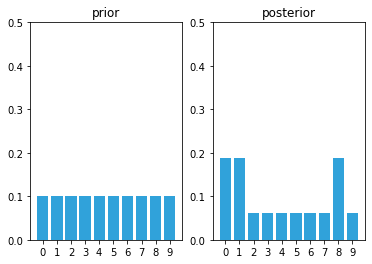

In [37]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
prior = np.array([0.1] * 10)
likelihood = lh_hallway(hallway, z=1, z_prob=0.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0, 0.5))

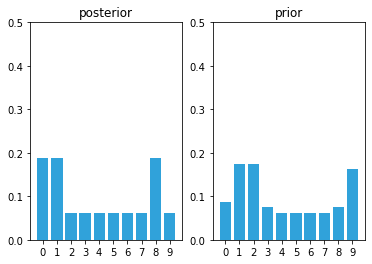

In [40]:
kernel = (0.1, 0.8, 0.1)
prior = predict(posterior, 1, kernel)
book_plots.plot_prior_vs_posterior(prior, posterior, True, ylim=(0., 0.5))

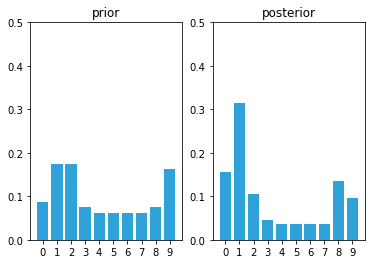

In [41]:
likelihood = lh_hallway(hallway, z=1, z_prob=0.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,0.5))

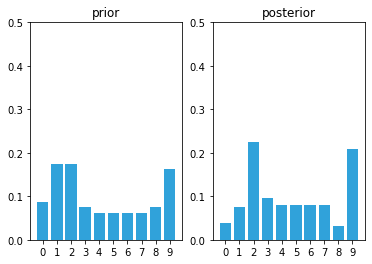

In [42]:
likelihood = lh_hallway(hallway, z=0, z_prob=0.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,0.5))

**Initialization**

1. Initialize our belief in the state


**Predict**

1. Based on the system behavior, predict state for the next time step

2. Adjust belief to account for the unvertainty in prediction


**Update**

1. Get a measurement and associated belief about its accuracy

2. Compute how likely it is the measurement mathces each state

3. Update state belief with this likelihood



In [43]:
def discrete_bayes_sim(priror, kernel, measurements, z_prob, hallway):
    posterior = np.array([0.1] * 10)
    priors = []
    posteriors = []
    for i, z in enumerate(measurements):
        prior = predict(posterior, 1, kernel)
        priors.append(prior)
        
        likelihood = lh_hallway(hallway, z, z_prob)
        posterior = update(likelihood, prior)
        posteriors.append(posterior)
    return priors, posteriors

In [49]:
def discrete_bayes_sim(prior, kernel, measurements, z_prob, hallway):
    posterior = np.array([.1]*10)
    priors, posteriors = [], []
    for i, z in enumerate(measurements):
        prior = predict(posterior, 1, kernel)
        priors.append(prior)

        likelihood = lh_hallway(hallway, z, z_prob)
        posterior = update(likelihood, prior)
        posteriors.append(posterior)
    return priors, posteriors


def plot_posterior(hallway, posteriors, i):
    plt.title('Posterior')
    book_plots.bar_plot(hallway, c='k')
    book_plots.bar_plot(posteriors[i], ylim=(0, 1.0))
    plt.axvline(i % len(hallway), lw=5)    
    
def plot_prior(hallway, priors, i):
    plt.title('Prior')
    book_plots.bar_plot(hallway, c='k')
    book_plots.bar_plot(priors[i], ylim=(0, 1.0), c='#ff8015')
    plt.axvline(i % len(hallway), lw=5)    

def animate_discrete_bayes(hallway, priors, posteriors):
    def animate(step):
        step -= 1
        i = step // 2    
        if step % 2 == 0:
            plot_prior(hallway, priors, i)
        else:
            plot_posterior(hallway, posteriors, i)
    
    return animate

In [53]:
kernel = (0.1, 0.8, 0.1)
z_prob = 1.0
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
zs = [hallway[i%len(hallway)] for i in range(50)]
priors, posteriors = discrete_bayes_sim(prior, kernel, zs, z_prob, hallway)
interact(animate_discrete_bayes(hallway, priors, posteriors), step=IntSlider(value=1, max=len(priors)*2))


interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

<function __main__.animate_discrete_bayes.<locals>.animate(step)>